In [1]:
import torchvision.transforms as T
from dataset import MultiCare_Thorax_XRay, MultiCare_Thorax_XRay_DataModule
from backend_central_dev.utils import plotting_utils
from torch.utils.data import DataLoader

# Define the learning rate for the optimizer
learning_rate = 1e-4

# Image size
image_size = 128

# Define the number of epochs for training
nepochs = 200

# Define the batch size for mini-batch gradient descent
batch_size = 16

tf = [T.Resize(size=(image_size, image_size)), T.ToTensor()]

train = MultiCare_Thorax_XRay(is_train=True, transform=tf,
                              download=True, verbose=True)
# print()
test = MultiCare_Thorax_XRay(is_train=False, transform=tf,
                             download=True, verbose=True)

Dataset exist:  /Users/yinnnyou/autodl-tmp/ml_data/multicare/multicare_radiology_thorax_xray
Saliency Dataset exist:  None
Train set, size: 2585
Dataset exist:  /Users/yinnnyou/autodl-tmp/ml_data/multicare/multicare_radiology_thorax_xray
Saliency Dataset exist:  None
Test set, size: 647


torch.Size([3, 128, 128])


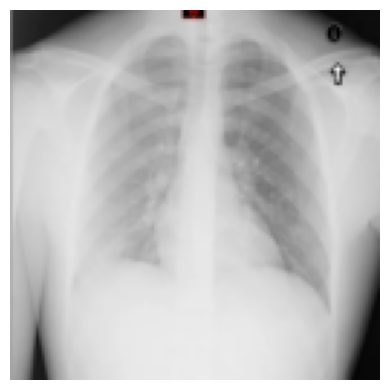

'Chest radiograph of the patient on admission, demonstrating a right lower lobe infiltrate.'

In [2]:
i = 109
print(train[i][0].shape)
plotting_utils.plot_hor([train[i][0].permute(1, 2, 0)])
train[i][1]

In [3]:
import transformers
from transformers import BlipProcessor, BlipForImageTextRetrieval, BlipForConditionalGeneration, AutoProcessor

In [4]:
# Load model from Huggingface Transformer library
processor = AutoProcessor.from_pretrained(
    "Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base")

model.to('mps')
model = model.train()

/Users/yinnnyou/anaconda3/envs/computing-solution/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [5]:
from torchvision.transforms.functional import InterpolationMode

dm = MultiCare_Thorax_XRay_DataModule(
    img_size=image_size,
    batch_size=batch_size,
    transform=[
        # T.RandomHorizontalFlip(),
        # T.RandomVerticalFlip(),
        # T.RandomAffine(degrees=[-40.0, 40.0], translate=[0.01, 0.12],
        #                shear=[-0.05, 0.05], interpolation=InterpolationMode.NEAREST, fill=0)
    ],
)
dm.setup('fit')
train_loader = dm.train_dataloader()

Applied transform for training: 
Compose(
      Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
      ToTensor()
)
Applied transform for validating: 
Compose(
      Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
      ToTensor()
)


In [6]:
# Start training
for epoch in range(5):
    print("Epoch:", epoch)
    for idx, batch in enumerate(train_loader):
        images, captions = batch

        images = images.to('mps')
        captions = captions

        encoding = processor(
            images=images, text=captions,
            padding="max_length", return_tensors="pt",
            do_rescale=False
        )

        outputs = model(input_ids=encoding["input_ids"].to('mps'),
                        attention_mask=encoding["attention_mask"].to('mps'),
                        pixel_values=encoding["pixel_values"].to('mps'),
                        labels=encoding["input_ids"].to('mps'))

        loss = outputs.loss

        # print("Loss:", loss.item())

      # loss.backward()

      # optimizer.step()
      # optimizer.zero_grad()
        break
#   print("Loss:", loss.item())
    break

Epoch: 0


In [ ]:
model.eval()
i = 421
image = test[i][0].to('mps')
caption = test[i][1]
print(caption)
print(image.device)

print('=======================')
inputs = processor(
    images=image,
    return_tensors="pt", do_rescale=False
).to('mps')
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
print('=======================')
generated_caption = processor.batch_decode(
    generated_ids, skip_special_tokens=True)[0]

print(generated_caption)

Chest X-ray of patient 3 showing a mildly increased cardiothoracic ratio and clear lung fields.
mps:0
a chest with a large, open lung


: 